In [75]:
%matplotlib inline
import numpy as np
import pandas as pd
import json
import math
import matplotlib.pyplot as plt
from init_objects import *
from functions.helpers import organise_data, hypothetical_series, get_specific_bootstraps_moments, confidence_interval
from functions.inequality import gini
from model import *
import statsmodels.api as sm
from matplotlib import style
from functions.evolutionaryalgo import *
import scipy.stats as stats

In [76]:
style.use('ggplot')

# Asset price volatility and wealth inequality

This notebook contains the following steps:

1. Parameter calibration and estimation
2. Model dynamics
3. Experiment

## 1 Parameter calibration and estimation

### 1.1 Collect data

In [77]:
shiller_data = pd.read_excel('http://www.econ.yale.edu/~shiller/data/ie_data.xls', header=7)[:-3]
p = pd.Series(np.array(shiller_data.iloc[1174:-1]['Price'])) #starting in 1952  was 1224
price_div = pd.Series(np.array(shiller_data.iloc[1174:-1]['CAPE']))
p_returns = pd.Series(np.array(shiller_data.iloc[1174:]['Price'])).pct_change()[1:]
pd_returns = pd.Series(np.array(shiller_data.iloc[1174:]['CAPE'])).pct_change()[1:]

In [78]:
emp_moments = np.array([
    p_returns.mean(),
    autocorrelation_returns(p_returns, 25),
    kurtosis(p_returns),
    ])

### 1.2 calibration

In [102]:
n_traders = 1000
trader_sample_size = 10

ticks = len(p)
init_stocks = (21780000000 / 267.33) / float(n_traders) # market valuation of Vanguard S&P 500 / share price 
risk_aversion = 0.7 # see http://keapaper.kea.ne.kr/RePEc/kea/keappr/KER-20121231-28-2-05.pdf
fundamental_value = p.mean()
stdev_fundamental_value = p.diff().std()
max_spread = 0.004087 # riordan & st

In [103]:
(21780000 / 267.33) / float(n_traders)

81.47233756031872

# Volatility inequality model

In [104]:
params = {"trader_sample_size": trader_sample_size, 
          "n_traders": n_traders,
          "init_stocks": init_stocks,
          "ticks": len(p), 
          "fundamental_value": fundamental_value,
          "std_fundamental": stdev_fundamental_value,
          "base_risk_aversion": risk_aversion,
          'spread_max': max_spread,
          "std_noise": 0.01, 
          "w_random": 0.1,
           "horizon": 200,
          "fundamentalist_horizon_multiplier": 1.2,
          "mean_reversion": 1.2,
          # fixed / not modelled parameters
          "strat_share_chartists": 0.0,
          "mutation_intensity": 0.0,
          "average_learning_ability": 0.0,
          "trades_per_tick": 1
         }

In [105]:
NRUNS = 10

In [106]:
trdrs0 = []
orbs0 = []
for seed in range(NRUNS): 
    traders0, orderbook0 = init_objects_distr(params, seed)
    traders0, orderbook0 = volatility_inequality_model2(traders0, orderbook0, params, seed)
    trdrs0.append(traders0)
    orbs0.append(orderbook0)

Start of simulation  0
Start of simulation  1
Start of simulation  2


C:\Users\joerischasfoort\Documents\GitHub\asset_volatility_wealth_inequality\functions\helpers.py:172: RuntimeWarning: invalid value encountered in log
  new_dr = np.exp(np.log((fundamental_value[-1]) + error + mean_reversion * (np.log(init_level) - np.log(fundamental_value[-1]))))


Start of simulation  3
Start of simulation  4
Start of simulation  5
Start of simulation  6
Start of simulation  7
Start of simulation  8
Start of simulation  9


In [107]:
orbs0[0].fundamental

[1101.1096156039398,
 1176.4306183891747,
 1204.2592384797688,
 1131.2979461751067,
 1057.5571684837475,
 1121.150563280252,
 1204.1171006089653,
 1185.4297248264652,
 1233.0352226587993,
 1283.6255866620288,
 1349.3247385801317,
 1387.9433543754965,
 1366.6019174542146,
 1372.40378236973,
 1388.795581097135,
 1382.7122974766557,
 1386.4676203569534,
 1311.2185771916918,
 1290.600613599442,
 1281.5757524343965,
 1317.7956450722706,
 1357.2678182537886,
 1307.5122261127362,
 1288.553668034443,
 1270.2476331652103,
 1255.2408123827554,
 1217.1372780608542,
 1263.0536184804707,
 1289.228607573461,
 1272.2852235235327,
 1255.9230937580044,
 1226.4191330383198,
 1127.2057257460835,
 1044.1005436937826,
 968.2620233815492,
 1025.1095945124225,
 929.325315293136,
 958.1606784907411,
 944.7691840869978,
 926.8207914491403,
 928.0078966897663,
 938.442773021139,
 946.0001394610237,
 948.7397026892586,
 957.0442982318216,
 959.139686335787,
 970.3519313054818,
 971.0259068905804,
 1002.105650890

In [108]:
mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals = organise_data(orbs0, burn_in_period=0)

In [109]:
lower_c_price = []
upper_c_price = []
for row in range(len(mc_fundamentals)):
    price_range = mc_prices.iloc[row]# / mc_fundamentals.iloc[row]
    lower, upper = confidence_interval(price_range, np.mean(price_range))
    lower_c_price.append(lower)
    upper_c_price.append(upper)

c:\users\joerischasfoort\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1920: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
c:\users\joerischasfoort\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1921: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc


Identify individual wealth changes

In [110]:
wealth_starts = []
wealth_ends = []
ginis_ot = []
palmas_ot = []
profits = []
real_profits = []
market_returns = []

# determine the start and end wealth of the bubble
for seed, traders in enumerate(trdrs0):
    money_start = np.array([x.var.money[0] for x in traders])
    stocks_start = np.array([x.var.stocks[0] for x in traders])
    wealth_start = money_start + (stocks_start * orbs0[seed].tick_close_price[0])

    money_end = np.array([x.var.money[-1] for x in traders])
    stocks_end = np.array([x.var.stocks[-1] for x in traders])
    wealth_end = money_end + (stocks_end * orbs0[seed].tick_close_price[-1])
    
    # profits
    profits.append((np.array(wealth_end) - np.array(wealth_start)) / np.array(wealth_start))
    real_profits.append(np.array(wealth_end) - np.array(wealth_start))
    market_returns.append([(orbs0[seed].tick_close_price[-1] - orbs0[seed].tick_close_price[0]) / orbs0[seed].tick_close_price[0] for x in range(len(wealth_start))])

    wealth_gini_over_time = []
    palma_over_time = []
    for t in range(params['ticks']):
        money = np.array([x.var.money[t] for x in traders])
        stocks = np.array([x.var.stocks[t] for x in traders])
        wealth = money + (stocks * orbs0[seed].tick_close_price[0])

        share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
        share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
        palma_over_time.append(share_top_10 / share_bottom_40)

        wealth_gini_over_time.append(gini(wealth))

    wealth_starts.append(list(wealth_start))
    wealth_ends.append(list(wealth_end))
    ginis_ot.append(wealth_gini_over_time)
    palmas_ot.append(palma_over_time)

In [111]:
av_gini_ot = []
low_gini_ot = []
up_gini_ot = []

av_palma_ot = []
low_palma_ot = []
up_palma_ot = []

for t in range(params['ticks']):
    t_gini = [g[t] for g in ginis_ot]
    av_gini_ot.append(np.mean(t_gini))
    low, up = confidence_interval(t_gini, np.mean(t_gini))
    low_gini_ot.append(low)
    up_gini_ot.append(up)

    t_palma = [p[t] for p in palmas_ot]
    av_palma_ot.append(np.mean(t_palma))
    low, up = confidence_interval(t_palma, np.mean(t_palma))
    low_palma_ot.append(low)
    up_palma_ot.append(up)

Text(0.5, 0, 'Agents')

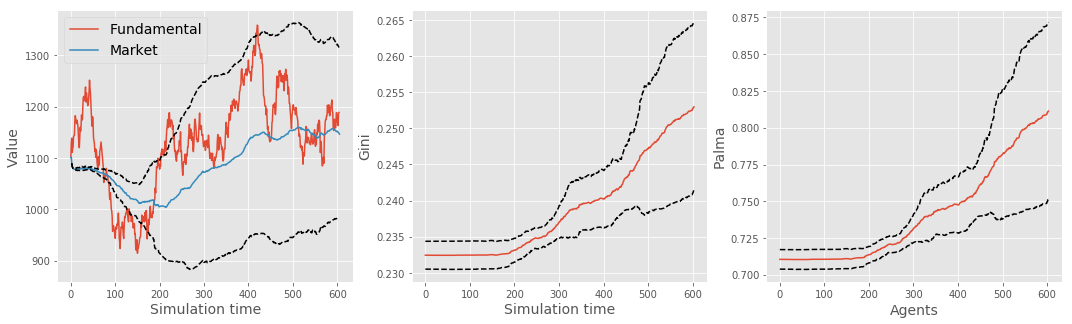

In [113]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))

ax1.plot(mc_fundamentals.index, mc_fundamentals.mean(axis=1), label='Fundamental')
#ax1.plot(mc_prices.index, (mc_prices.mean(axis=1) / mc_fundamentals.mean(axis=1))[:], label='Market')
ax1.plot(mc_prices.index, mc_prices.mean(axis=1), label='Market')
ax1.plot(mc_prices.index[:-1], lower_c_price, 'k--')
ax1.plot(mc_prices.index[:-1], upper_c_price, 'k--')
ax1.legend(loc='best', fontsize='14')

ax1.set_ylabel('Value', fontsize='14')

ax2.plot(range(len(av_gini_ot[:])), av_gini_ot[:])
ax2.plot(range(len(low_gini_ot[:])), low_gini_ot[:], 'k--')
ax2.plot(range(len(up_gini_ot[:])), up_gini_ot[:], 'k--')
ax2.set_ylabel('Gini', fontsize='14')

ax3.plot(range(len(av_gini_ot[:])), av_palma_ot[:])
ax3.plot(range(len(low_gini_ot[:])), low_palma_ot[:], 'k--')
ax3.plot(range(len(up_gini_ot[:])), up_palma_ot[:], 'k--')
ax3.set_ylabel('Palma', fontsize='14')


for ax in (ax1, ax2, ax3):
    ax.set_xlabel('Simulation time', fontsize='14')
    
ax3.set_xlabel('Agents', fontsize='14')

#fig.savefig('baseline_dynamics.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

# Experiment 

In [28]:
stdev_fun = [x / 100.0 for x in range(0, 20000, 2000)]

In [29]:
NRUNS = 5

In [30]:
stdev_fun[0] = 0.0001

In [31]:
stdev_fun

[0.0001, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 140.0, 160.0, 180.0]

In [32]:
experiments = len(stdev_fun)

In [33]:
trdrs = []
orbs = []
for exp in range(experiments):
    params['std_fundamental'] = stdev_fun[exp]
    for seed in range(NRUNS): 
        traders, orderbook = init_objects_distr(params, seed)
        traders, orderbook = volatility_inequality_model2(traders, orderbook, params, seed)
        trdrs.append(traders)
        orbs.append(orderbook)

Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of si

In [34]:
full_stdev_fun = []
for exp in range(experiments):
    for seed in range(NRUNS):
        full_stdev_fun.append(stdev_fun[exp])

In [35]:
ginis = []
palmas = []

for idx, traders in enumerate(trdrs):
    money = np.array([x.var.money[-1] for x in trdrs[idx]])
    stocks = np.array([x.var.stocks[-1] for x in trdrs[idx]])
    wealth = money + (stocks * orbs[idx].tick_close_price[-1])
    
    share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
    share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
    palmas.append(share_top_10 / share_bottom_40)
    
    ginis.append(gini(wealth))

In [36]:
# calc redistribution, profits ... abs 
profits = []

# determine the start and end wealth of the bubble
for seed, traders in enumerate(trdrs):
    money_start = np.array([x.var.money[0] for x in traders])
    stocks_start = np.array([x.var.stocks[0] for x in traders])
    wealth_start = money_start + (stocks_start * orbs[seed].tick_close_price[0])

    money_end = np.array([x.var.money[-1] for x in traders])
    stocks_end = np.array([x.var.stocks[-1] for x in traders])
    wealth_end = money_end + (stocks_end * orbs[seed].tick_close_price[-1])
    
    # profits
    profits.append((np.array(wealth_end) - np.array(wealth_start)) / np.array(wealth_start))

In [37]:
# split the data in parts of 10 
gini_averages = []
gini_conf_interval_uppers = []
gini_conf_intervals_lowers = []

palma_averages = []
palma_conf_interval_uppers = []
palma_conf_intervals_lowers = []

for x in range(experiments):
    y = x*NRUNS
    g = ginis[y:y+NRUNS]
    
    gini_averages.append(np.mean(g))
    sample_stdev = np.std(g)
    sigma = sample_stdev/math.sqrt(len(g))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(g), scale = sigma) 
    gini_conf_interval_uppers.append(min(upper, 1.0))
    gini_conf_intervals_lowers.append(lower)
    
    p = palmas[y:y+NRUNS]
    palma_averages.append(np.mean(p))
    sample_stdev = np.std(p)
    sigma = sample_stdev/math.sqrt(len(p))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(p), scale = sigma) 
    palma_conf_interval_uppers.append(upper)
    palma_conf_intervals_lowers.append(max(lower, 0))

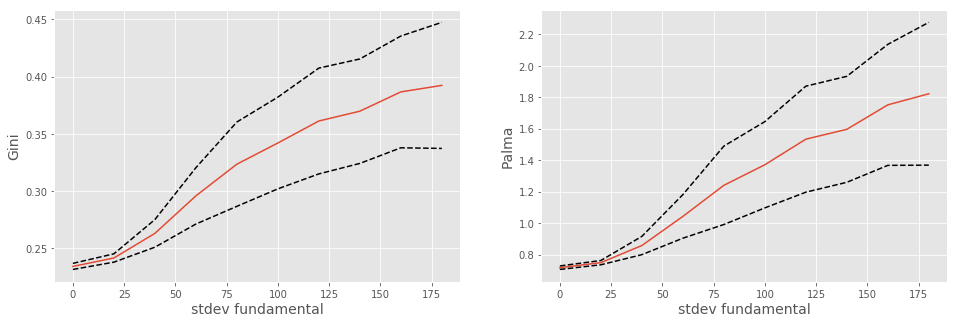

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,5])

ax1.plot(stdev_fun, gini_averages)
ax1.plot(stdev_fun, gini_conf_interval_uppers, 'k--')
ax1.plot(stdev_fun, gini_conf_intervals_lowers, 'k--')

ax2.plot(stdev_fun, palma_averages)
ax2.plot(stdev_fun, palma_conf_interval_uppers, 'k--')
ax2.plot(stdev_fun, palma_conf_intervals_lowers, 'k--')

ax1.set_ylabel('Gini', fontsize=14)
ax2.set_ylabel('Palma', fontsize=14)

for ax in [ax1, ax2]:
    ax.set_xlabel('stdev fundamental', fontsize=14)

fig.savefig('stdev_f_inequality.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)